# pan-Arctic classified slope and aspect maps (Geo computation only)
## Alexandra Hamm

## Background

Information about the geomorphology of permafrost landscapes can not only provide information about the extend and presence of permafrost, but also about the governing hydrological processes in the subsurface. In the current study of my PhD, model results have shown that the slope of a landscape influences the distribution of water and moisture throughout the slope, which causes temperature differences in the uphill vs. the downhill section. This is due to differences in evaporation and infiltration as well as heat capacity. How important these effects are on a pan-Arctic scale, depends on the frequency and distribution of slopes as they have been simulated in the study as well as on the climatic conditions. To see how representative the modeled landscape in the study is for the entire Arctic, I took on this project, and calculated and classified slopes in different regions around the Arctic. Further, I also calculated the aspect of the different regions since slope and aspect often go together. The results show, however, that there is no preferential aspect in most of the regions.

The results from this project will help improving my manuscript and address a reviewers comment about the 'upscalability' of my model results.


## Aim

The aim of this project is to classify the landscape around the Arctic based on terrain properties. I am interested in slope inclinations, specifically in four major classes of slopes:

1. (almost) flat terrain (<5° inclination)
2. medium slopes (5-15° inclination)
3. steep slopes (15-25° inclination) 
4. very steep slopes (>25° inclination)

as well as aspect, classified into 9 classes:

1. Flat (-1)
2. North (0° to 22.5° and 337.5° to 360°)
3. Northeast (22.5° to 67.5°)
4. East (67.5° to 112.5°)
5. Southeast (112.5° to 157.5°)
6. South (157.5° to 202.5°)
7. Southwest (202.5° to 247.5°)
8. West (247.5° to 292.5°)
9. Northwest (292.5° to 337.5°)

To calculate the terrain properties, the pan-Arctic digital elevation model ArcticDEM in 10m resolution is used. The following datasets have been aquired for this project:
* ArcticDEM tiles (https://www.pgc.umn.edu/data/arcticdem/)
* ArcticDEM index shapefile (https://www.pgc.umn.edu/data/arcticdem/)
* TM world borders shapefile (https://thematicmapping.org/downloads/world_borders.php)
* Administrative regions of the US, Canada and Russia (https://www.weather.gov/gis/USStates, https://www12.statcan.gc.ca/census-recensement/2011/geo/bound-limit/bound-limit-2011-eng.cfm , https://mydata.biz/ru/catalog/databases/borders_ru)
* A pan-Arctic permafrost map with permafrost classified in continous, discontinous sporadic and isolated permafrost (https://nsidc.org/data/ggd318)

This document summarizes the thought-process as well as the (very short) scripts to process the data

## Challenges

* Even in 10m resolution: ArcticDEM files are very big (up to 400mb per tile and up to 500 tiles per region)
* Creating one big DEM to analyze is not possible
* **Solution**: Focusing on regions and download files for each region separately


## Workflow

* Select regions to be considered:
    * **USA**: Alaska
    * **Canada**: Yukon, Northwest Territories, Nunavut
    * **Norway**: Svalbard
    * **Denmark**: Greenland
    * **Russia**: Ural, Northwest, Siberia, Far east
* Export shapefile with region of interest with ogr2ogr

Some regions can directly extracted from the TM World shapefile. The others have been retrieved from national boundary shapefiles. The example below shows how to extract a region (Greenland and Svalbard) from the TM_WORLD.shp 

* Clip the new shapefile by the continuous permafrost extend within each region
* Clip the ArcticDEM index shapefile by the resulting region (with continuous permafrost) to find the tiles wihtin the region
* Use ogrinfo to extract a list with the unique ArcticDEM tiles 
* Save the list as basis for download

In [ ]:
%%bash
# this is the script I ran as a .sh file. Hence the /bin/bash
#!/bin/bash

declare -a provinces=("Svalbard" "Greenland")
for PROVINCE in "${provinces[@]}" ; do
    STRINGFIX=${PROVINCE// /_} # in case of the russian regions, spaces needed to changed to underscores (Siberia Federal District to Siberia_Federal_District)
    cd /home/alex/modeling/data/arcticdem/
    mkdir $STRINGFIX
    ogr2ogr -where NAME="'$PROVINCE'" ${STRINGFIX}_3413.shp ../ArcticDEM_Tile_Index_Rel7/TM_WORLD_3413.shp
    ogr2ogr -clipsrc ../ArcticDEM_Tile_Index_Rel7/cont_permafrost_3413.shp ${STRINGFIX}_cont_permafrost_3413.shp ${STRINGFIX}_3413.shp
    ogr2ogr -clipsrc ${STRINGFIX}_cont_permafrost_3413.shp ${STRINGFIX}_tiles.shp ../ArcticDEM_Tile_Index_Rel7/ArcticDEM_Tile_Index_Rel7.shp
    echo extracting tile list
    ogrinfo -al ${STRINGFIX}_tiles.shp -geom=NO | grep 'tile (String)' | sort | uniq | awk '{ print $4 }' > $STRINGFIX/tile_list.txt
done


Tile lists look like this:

In [2]:
%%bash 
less tile_list.txt

33_51
33_52
33_53
33_56
34_50
34_51
34_52
34_53
35_50
35_51
35_52
35_53
35_54
36_50
36_51
36_52
36_53
36_54
37_50
37_51
37_52
38_51


Based on the tile list the tiles are downloaded, unzipped, processed and deleted to save disk space. Processing steps include (with input from the command line):
* Download ArcticDEM tile based on the tile list
* Extracting the dem-tif file from zip archive
* Mask the area of interest (continuous permafrost) and discard artifacts over water
* Calculate the slope/aspect based on the DEM
* reclassify image (with gdal_calc) into the classes mentioned in the beginning
* Calculate the histogram
* Extract the sum of pixels from the histogram in the corresponding class
* Adding the tile to list of counted pixels
* Adding this information to the file, which collects the data (all_tiles_XXX.txt)
* remove the bulky files and display progress


In [ ]:
%%bash

#!/bin/bash
direc=$1
cd /home/alex/modeling/data/arcticdem/${direc}
subdirec=$(basename $PWD)
rm all_tiles_slope_${subdirec}.txt
touch all_tiles_slope_${subdirec}.txt
rm all_tiles_aspect_${subdirec}.txt
touch all_tiles_aspect_${subdirec}.txt
file_count=$(less tile_list.txt | wc -l)
counter=1

while read entry; do
    # downloading
    echo downloading tile $entry...
    wget -q http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/mosaic/v3.0/10m/$entry/${entry}_10m_v3.0.tar.gz
    # unzipping
    tar -xzvf ${entry}_10m_v3.0.tar.gz -C /home/alex/modeling/data/arcticdem/${direc} ${entry}_10m_v3.0_reg_dem.tif
    # extracting extend
    ulx=$(gdalinfo ${entry}_10m_v3.0_reg_dem.tif | grep "Upper Left" | awk '{ gsub ("[(),]"," ") ; print  $3  }')
    uly=$(gdalinfo ${entry}_10m_v3.0_reg_dem.tif | grep "Upper Left" | awk '{ gsub ("[(),]"," ") ; print  $4  }')
    lrx=$(gdalinfo ${entry}_10m_v3.0_reg_dem.tif | grep "Lower Right" | awk '{ gsub ("[(),]"," ") ; print $3  }')
    lry=$(gdalinfo ${entry}_10m_v3.0_reg_dem.tif | grep "Lower Right" | awk '{ gsub ("[(),]"," ") ; print $4  }')
    # "clipping" mask to extend of the tif
    gdalwarp -ot Byte -te $ulx $lry $lrx $uly -tr 10 10 -co COMPRESS=DEFLATE -co ZLEVEL=9  ../${subdirec}_cont_permafrost_raster.tif mask_subset.tif -overwrite
    gdal_edit.py -a_ullr $ulx $uly $lrx $lry mask_subset.tif
    # mask values in the .tif with the new mask so that only values inside the continuous permafrost area are considered
    pksetmask -m mask_subset.tif -msknodata 0 -nodata -9999 -i ${entry}_10m_v3.0_reg_dem.tif -o ${entry}_msk.tif
    # calculate SLOPE
    gdaldem slope ${entry}_msk.tif ${entry}_slope.tif
    # This next command is an alternative classification in commonly recognized slope classes
    #gdal_calc.py -A ${entry}_slope.tif --outfile=${entry}_reclass.tif --calc="1*(A<=3)+2*((A>3)*(A<=9))+3*((A>9)*(A<=15))+4*((A>15)*(A<=30))+5*((A>30)*(A<=60))+6*(A>60)" --overwrite
    # reclassify values so they fall within the classes of interest
    gdal_calc.py -A ${entry:0:5}_slope.tif --outfile=${entry:0:5}_reclass.tif --calc="0*(A<=5)+10*((A>5)*(A<=15))+20*((A>15)*(A<=25))+30*(A>25)" --overwrite
    # calculate histogram
    pkstat --hist -src_min 0 -src_max 35 -i ${entry}_reclass.tif > ${entry}_hist_temp.txt
    # extract the values with the 4 different classes
    sed -n -e 1p -e 11p -e 21p -e 31p ${entry:0:5}_hist_temp.txt > ${entry:0:5}_hist_values_temp.txt
    #sed -n -e 2p -e 3p -e 4p -e 5p -e 6p -e 7p ${entry}_hist_temp.txt > ${entry}_hist_values_temp.txt
    # use awk to only get the actual number, not the class-value
    awk  '{ print $2 }' ${entry}_hist_values_temp.txt > ${entry}_pixel_count_temp.txt
    # save the name of the tile as additional information
    echo ${entry} >> ${entry}_pixel_count_temp.txt
    # paste ouptut into a file that collects all the histogram values for all the tiles
    less ${entry}_pixel_count_temp.txt >> all_tiles_slope_${subdirec}.txt
    # Repeat the same process with different classes for ASPECT
    gdaldem aspect ${entry}_msk.tif ${entry}_aspect.tif
    gdal_calc.py -A ${entry}_aspect.tif --outfile=${entry}_reclass_as.tif --calc="1*(A==-1)+2*((A>=0)*(A<=22.5))+3*((A>22.5)*(A<=67.5))+4*((A>67.5)*(A<=112.5))+5*((A>112.5)*(A<=157.5))+6*((A>157.5)*(A<=202.5))+7*((A>202.5)*(A<=247.5))+8*((A>247.5)*(A<=292.5))+9*((A>292.5)*(A<=337.5))+2*((A>337.5)*(A<=360))" --overwrite
    pkstat --hist -src_min 0 -src_max 35 -i ${entry}_reclass_as.tif > ${entry}_hist_as_temp.txt
    sed -n -e 2p -e 3p -e 4p -e 5p -e 6p -e 7p -e 8p -e 9p -e 10p ${entry}_hist_as_temp.txt > ${entry}_hist_values_as_temp.txt
    awk  '{ print $2 }' ${entry}_hist_values_as_temp.txt > ${entry}_pixel_count_as_temp.txt
    echo ${entry} >> ${entry}_pixel_count_as_temp.txt
    less ${entry}_pixel_count_as_temp.txt >> all_tiles_aspect_${subdirec}.txt
    # remove tmeporary files and all the tiffs to save space
    rm *.tif
    rm *_temp.txt
    # print progress
    echo progress: $counter/$file_count
    # increase counter
    ((counter++))
    rm *.tar.gz
done <tile_list.txt


## Displaying data

The final product is meant to be a summary of slopes and aspects in the different regions. In python, the percentages of each class are being calculated and displayed in a pie chart

processing Alaska
processing Yukon
processing Northwest Territories
processing Quebec
processing Nunavut
processing Greenland
processing Svalbard
processing Northwest
processing Ural
processing Siberia
processing Far East


/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


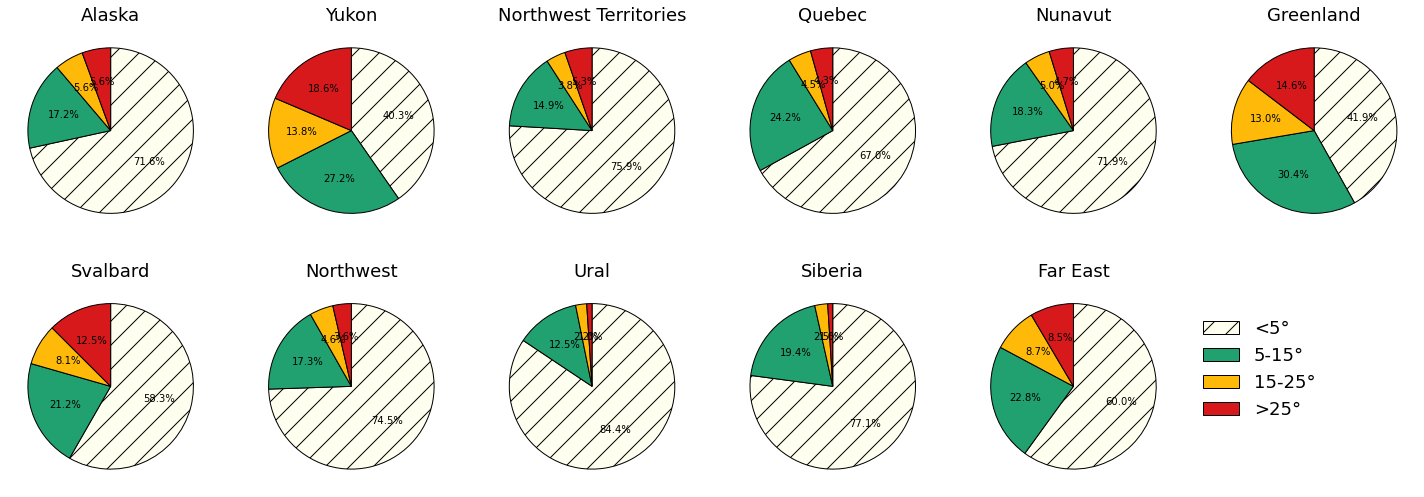

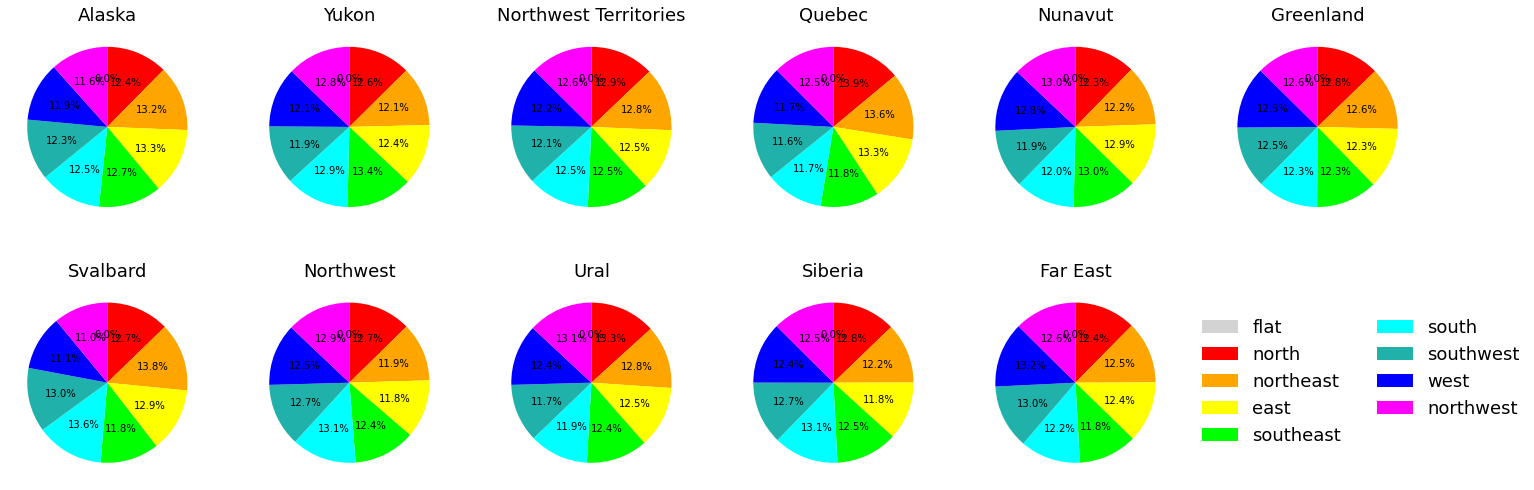

In [40]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
import os
from tabulate import tabulate
import pandas as pd
from IPython.display import Image

os.chdir('/home/alex/Documents/courses/geocomputation/project/percentages/')
areas = ['Alaska', 'Yukon' ,'Northwest Territories', 'Quebec', 
           'Nunavut',  'Greenland', 'Svalbard','Northwest', 
           'Ural', 'Siberia', 'Far East']
flnames = ['Alaska', 'Yukon' ,'Northwest_Territories', 'Quebec', 
           'Nunavut',  'Greenland', 'Svalbard','Northwestern_Federal_District', 
           'Ural_Federal_District', 'Siberian_Federal_District', 'Far_Eastern_Federal_District']
fig, axs = plt.subplots(2,6, figsize = (20,8))
axs = axs.ravel()
fig2, axs2 = plt.subplots(2,6, figsize = (20,8))
axs2 = axs2.ravel()
slope_tab = np.zeros((len(areas),4))

colnames = ['<5°', '5-15°', '15-25°', '>25°']

for j in range(len(areas)):
    ns_percent = np.genfromtxt('all_tiles_slope_'+flnames[j]+'.txt', dtype='str')
    aspect_percent = np.genfromtxt('all_tiles_aspect_'+flnames[j]+'.txt', dtype='str')

    app = lambda y: [np.float(i) for i in y]
    ns_tile = ns_percent[4::5]
    slope_5 = np.apply_along_axis(app, 0, ns_percent[0::5])
    slope_15 = np.apply_along_axis(app, 0, ns_percent[1::5])
    slope_25 = np.apply_along_axis(app, 0, ns_percent[2::5])
    slope_rest = np.apply_along_axis(app, 0, ns_percent[3::5])
    
    as_flat = np.apply_along_axis(app, 0, aspect_percent[0::10])
    as_n = np.apply_along_axis(app, 0, aspect_percent[1::10])
    as_ne = np.apply_along_axis(app, 0, aspect_percent[2::10])
    as_e = np.apply_along_axis(app, 0, aspect_percent[3::10])
    as_se = np.apply_along_axis(app, 0, aspect_percent[4::10])
    as_s = np.apply_along_axis(app, 0, aspect_percent[5::10])
    as_sw = np.apply_along_axis(app, 0, aspect_percent[6::10])
    as_w = np.apply_along_axis(app, 0, aspect_percent[7::10])
    as_nw = np.apply_along_axis(app, 0, aspect_percent[8::10])
    
    as_df = pd.DataFrame({'tile':ns_tile, 'f':as_flat, 'n': as_n, 'ne': as_ne, 'e':as_e, 'se':as_se, 's':as_s, 'sw':as_sw, 'w': as_w, 'nw': as_nw})
    as_df['tot_pixels'] = as_df.iloc[:,1:].sum(axis=1)
    as_names = ['flat','north', 'northeast', 'east', 'southeast', 'south', 'southwest', 'west', 'northwest']

    df = pd.DataFrame({'tile':ns_tile, '<5':slope_5, '5-15': slope_15, '15-25': slope_25, '>25':slope_rest})
    df['tot_pixels'] = df.iloc[:,1:].sum(axis=1)
    
    c_names = ['p5', 'p15', 'p25', 'prest']
    for i in range(4):
        df[c_names[i]] = df.iloc[:,i+1]/df.iloc[:,5]*100
    
    for i in range(9):
        as_df[as_names[i]] = as_df.iloc[:,i+1]/as_df['tot_pixels']*100
        
    print('processing '+areas[j])
    
    slope_tab[j,0] = round(df['p5'].mean(),2)
    slope_tab[j,1] = round(df['p15'].mean(),2)
    slope_tab[j,2] = round(df['p25'].mean(),2)
    slope_tab[j,3] = round(df['prest'].mean(),2)


    as_colors = ['lightgrey','red', 'orange', 'yellow', 'lime', 'cyan', 'lightseagreen', 'blue', 'magenta']
    cols = ['ivory', '#21a170', '#ffba09', '#d7191c']
    
    group_mean = df.iloc[:,6:].mean().to_frame(name='percent')
    patches = axs[j].pie(group_mean['percent'], counterclock=False,colors=cols, autopct='%1.1f%%',
                      startangle=90,wedgeprops={"edgecolor":"0",'linewidth': 1, 'antialiased': True})[0]
    patches[0].set_hatch('/')
    axs[j].set_ylabel('')
    axs[j].set_title(areas[j],fontsize=18)
    fig.tight_layout() 

    if j == len(areas)-1:
        axs[j].legend(colnames,frameon=False,bbox_to_anchor=(1.05, 0.9), fontsize=18)
    
    aspect_mean = as_df.iloc[:,11:].mean().to_frame(name='percent')
    aspect_mean.plot.pie(y='percent',colors=as_colors,startangle=90,counterclock=False, labels=None,ax=axs2[j],autopct='%1.1f%%')
    axs2[j].set_ylabel('')
    axs2[j].set_title(areas[j],fontsize=18)
    if j != len(areas)-1:
        axs2[j].get_legend().remove()
    else:
        axs2[j].legend(labels=as_names,frameon=False,bbox_to_anchor=(1.05, 0.9), fontsize=18, ncol=2)
    fig2.tight_layout() 

fig.delaxes(axs[11])
fig2.delaxes(axs2[11])

fig.savefig('plot/pieCharts.svg', dpi=300, bbox_inches='tight')

To show the actual values better, tables are being constructed which can be used for latex and markdown

In [10]:
col_str = 'r|rrrr'
pd_t = pd.DataFrame(slope_tab, index = areas, columns = colnames)
# latex table format
print(pd_t.to_latex(column_format=col_str))
# markdown table format
print(tabulate(pd_t, tablefmt="pipe", headers="keys"))

\begin{tabular}{r|rrrr}
\toprule
{} &    <5° &  5-15° &  15-25° &   >25° \\
\midrule
Alaska                &  71.60 &  17.19 &    5.63 &   5.58 \\
Yukon                 &  40.34 &  27.21 &   13.84 &  18.61 \\
Northwest Territories &  75.93 &  14.94 &    3.80 &   5.33 \\
Quebec                &  67.00 &  24.21 &    4.47 &   4.33 \\
Nunavut               &  71.94 &  18.32 &    4.99 &   4.74 \\
Greenland             &  41.89 &  30.44 &   13.03 &  14.64 \\
Svalbard              &  58.27 &  21.16 &    8.05 &  12.52 \\
Northwest             &  74.47 &  17.31 &    4.63 &   3.60 \\
Ural                  &  84.36 &  12.45 &    2.16 &   1.03 \\
Siberia               &  77.11 &  19.40 &    2.52 &   0.97 \\
Far East              &  59.99 &  22.82 &    8.70 &   8.49 \\
\bottomrule
\end{tabular}

|                       |   <5° |   5-15° |   15-25° |   >25° |
|:----------------------|------:|--------:|---------:|-------:|
| Alaska                | 71.6  |   17.19 |     5.63 |   5.58 |
| Yukon       

Table with values

|                       |   <5° |   5-15° |   15-25° |   >25° |
|:----------------------|------:|--------:|---------:|-------:|
| Alaska                | 71.6  |   17.19 |     5.63 |   5.58 |
| Yukon                 | 40.34 |   27.21 |    13.84 |  18.61 |
| Northwest Territories | 75.93 |   14.94 |     3.8  |   5.33 |
| Quebec                | 67    |   24.21 |     4.47 |   4.33 |
| Nunavut               | 71.94 |   18.32 |     4.99 |   4.74 |
| Greenland             | 41.89 |   30.44 |    13.03 |  14.64 |
| Svalbard              | 58.27 |   21.16 |     8.05 |  12.52 |
| Northwest             | 74.47 |   17.31 |     4.63 |   3.6  |
| Ural                  | 84.36 |   12.45 |     2.16 |   1.03 |
| Siberia               | 77.11 |   19.4  |     2.52 |   0.97 |
| Far East              | 59.99 |   22.82 |     8.7  |   8.49 |

## Final map for reviewer response and manuscript

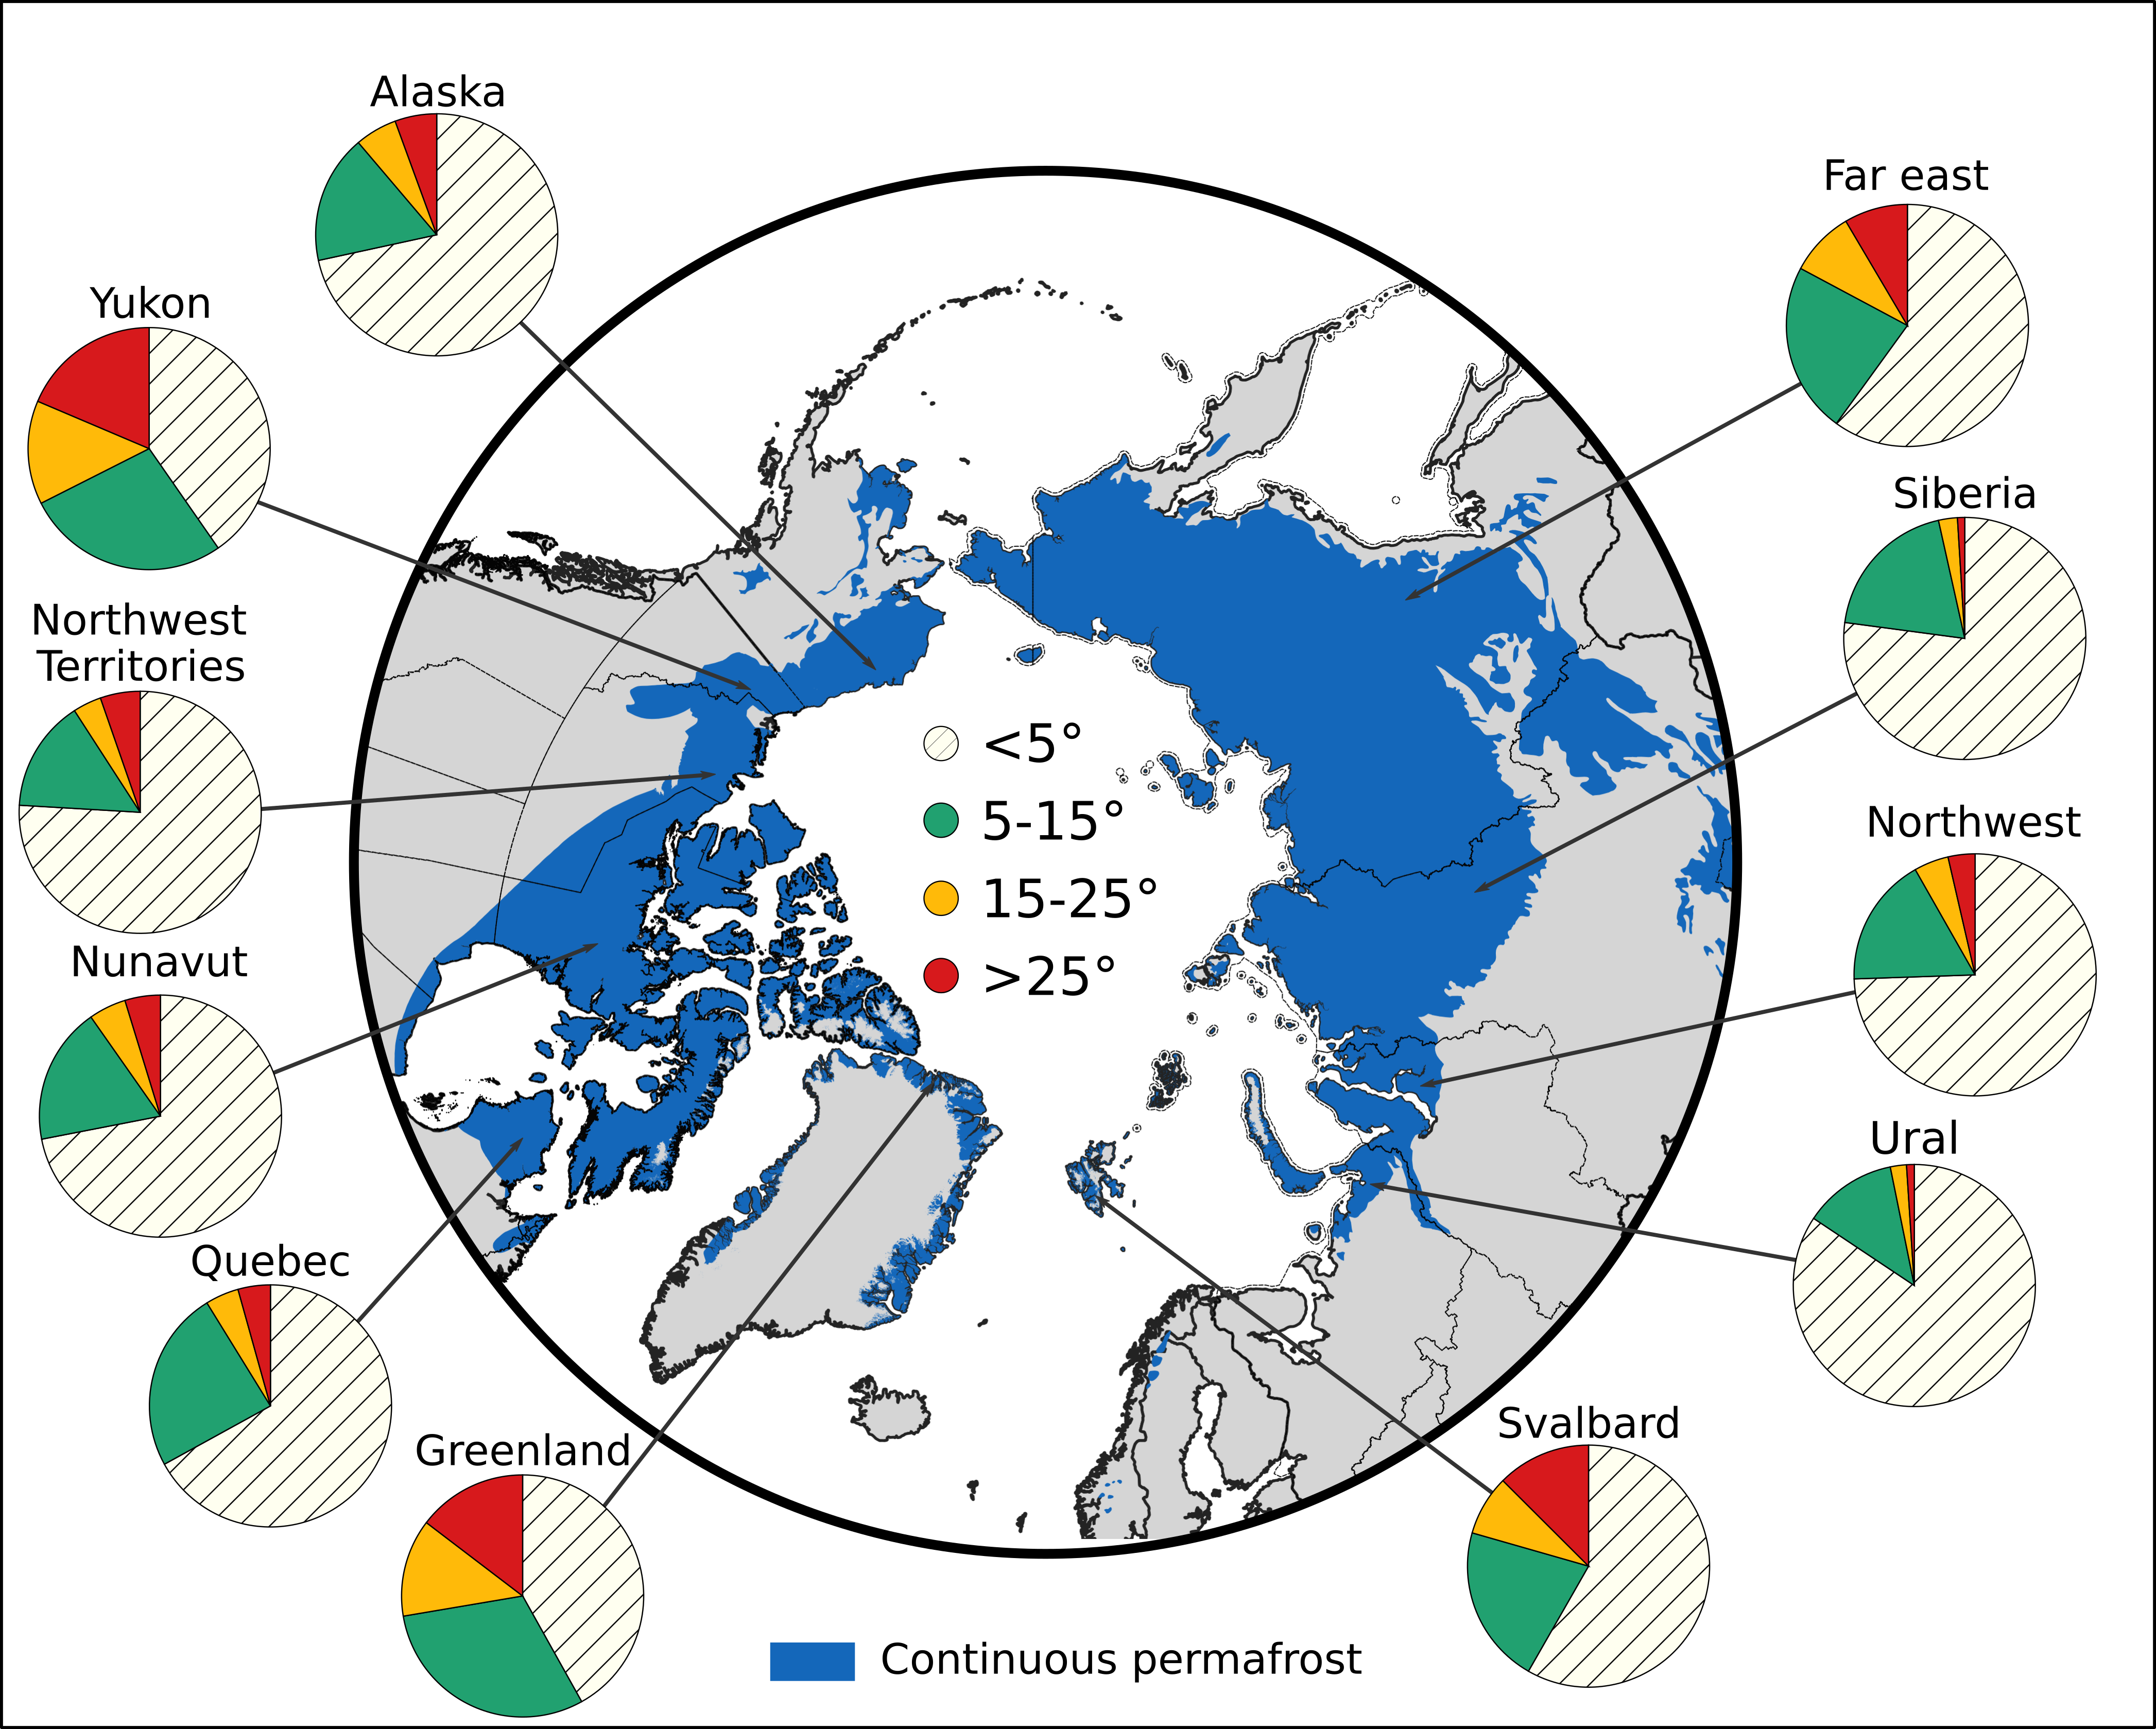

In [35]:
Image('../slope_map.png')